In [2]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import os
from utility.ffqd_mnist import FFQD_Dataset, label_for_id
from torch.utils.data import DataLoader

training_data = FFQD_Dataset('ffqd_mnist/', train=True)
train_dataloader = DataLoader(training_data, batch_size=64)

test_data = FFQD_Dataset('ffqd_mnist/')
test_dataloader = DataLoader(test_data, batch_size=64)
device = 'cpu'

In [3]:
class MLP(torch.nn.Module):
    def __init__(self, input_size = 784, output_size=10):
        super(MLP, self).__init__()
        # self.fc = torch.nn.Linear(input_size,output_size)
        # self.relu = torch.nn.ReLU()
        # self.linear1 = nn.Linear(input_size, 512)
        # self.relu1 = nn.ReLU()
        self.mlp_stack = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, output_size)
        )

    def forward(self, x):
        # y  = self.linear1(x)
        # y = self.relu1(y)
        y = self.mlp_stack(x)
        return y

In [4]:
model = MLP()
optimizer = torch.optim.SGD(model.parameters(), lr=.01)
criterion = torch.nn.CrossEntropyLoss()

def reset_model():
    global model, optimizer
    model = MLP()
    optimizer = torch.optim.SGD(model.parameters(), lr=.01)


In [5]:
def train_one_epoch(dataloader, model, loss_fn, optimizer):
    model.train()
    for batch_id, (X,y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # calculate loss
        y_pred = model(X)
        loss = loss_fn(y_pred, y)


        # print( y_pred.dtype, y_pred.shape)
        # print(loss)

        # backprop loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_id % 100 == 0:
            print(f"({batch_id}) loss: {loss:>7}")


In [6]:
def test_one_epoch(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X,y in dataloader:
            X, y = X.to(device), y.to(device)
            pred_y = model(X)
            test_loss += loss_fn(pred_y, y).item()
            correct += (pred_y.argmax(1) == y.argmax(1)).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    return test_loss, correct


In [7]:
reset_model()
# old_weights = torch.Tensor(np.array(model.get_parameter("fc.weight").detach().numpy())) # copy old weights
old_weights = model.get_parameter("mlp_stack.0.weight").clone().detach()
for i in range(5):
    train_one_epoch(train_dataloader, model, criterion, optimizer)
    print(test_one_epoch(test_dataloader, model, criterion))

(0) loss: 2.3017239309847355
(100) loss: 2.2640648186206818
(200) loss: 2.1901773512363434
(300) loss: 2.047956246882677
(400) loss: 1.8182934615761042
(500) loss: 1.553409257903695
(600) loss: 1.4530071187764406
(700) loss: 1.147368541918695
(800) loss: 1.0754126808606088
(1.066558231719248, 0.6846363636363636)
(0) loss: 1.127660624217242
(100) loss: 1.0275901254499331
(200) loss: 0.9859685341943987
(300) loss: 0.8021247996948659
(400) loss: 0.974779362033587
(500) loss: 0.8746102580917068
(600) loss: 0.9510250351158902
(700) loss: 0.6588595543289557
(800) loss: 0.7447384141851217
(0.798614352802261, 0.7578)
(0) loss: 0.8700465027432074
(100) loss: 0.6903789399657398
(200) loss: 0.8048130257666344
(300) loss: 0.5827251023729332
(400) loss: 0.8645329307037173
(500) loss: 0.7536605461427826
(600) loss: 0.8282022797502577
(700) loss: 0.5651579657496768
(800) loss: 0.6866220625743154
(0.7187834372216901, 0.7846909090909091)
(0) loss: 0.7939627006580849
(100) loss: 0.584481921599945
(200) 

### And now ?
<pre>


















</pre>



In [8]:
for name, par in model.named_parameters():
    print(name, par.shape)

mlp_stack.0.weight torch.Size([512, 784])
mlp_stack.0.bias torch.Size([512])
mlp_stack.2.weight torch.Size([512, 512])
mlp_stack.2.bias torch.Size([512])
mlp_stack.4.weight torch.Size([10, 512])
mlp_stack.4.bias torch.Size([10])


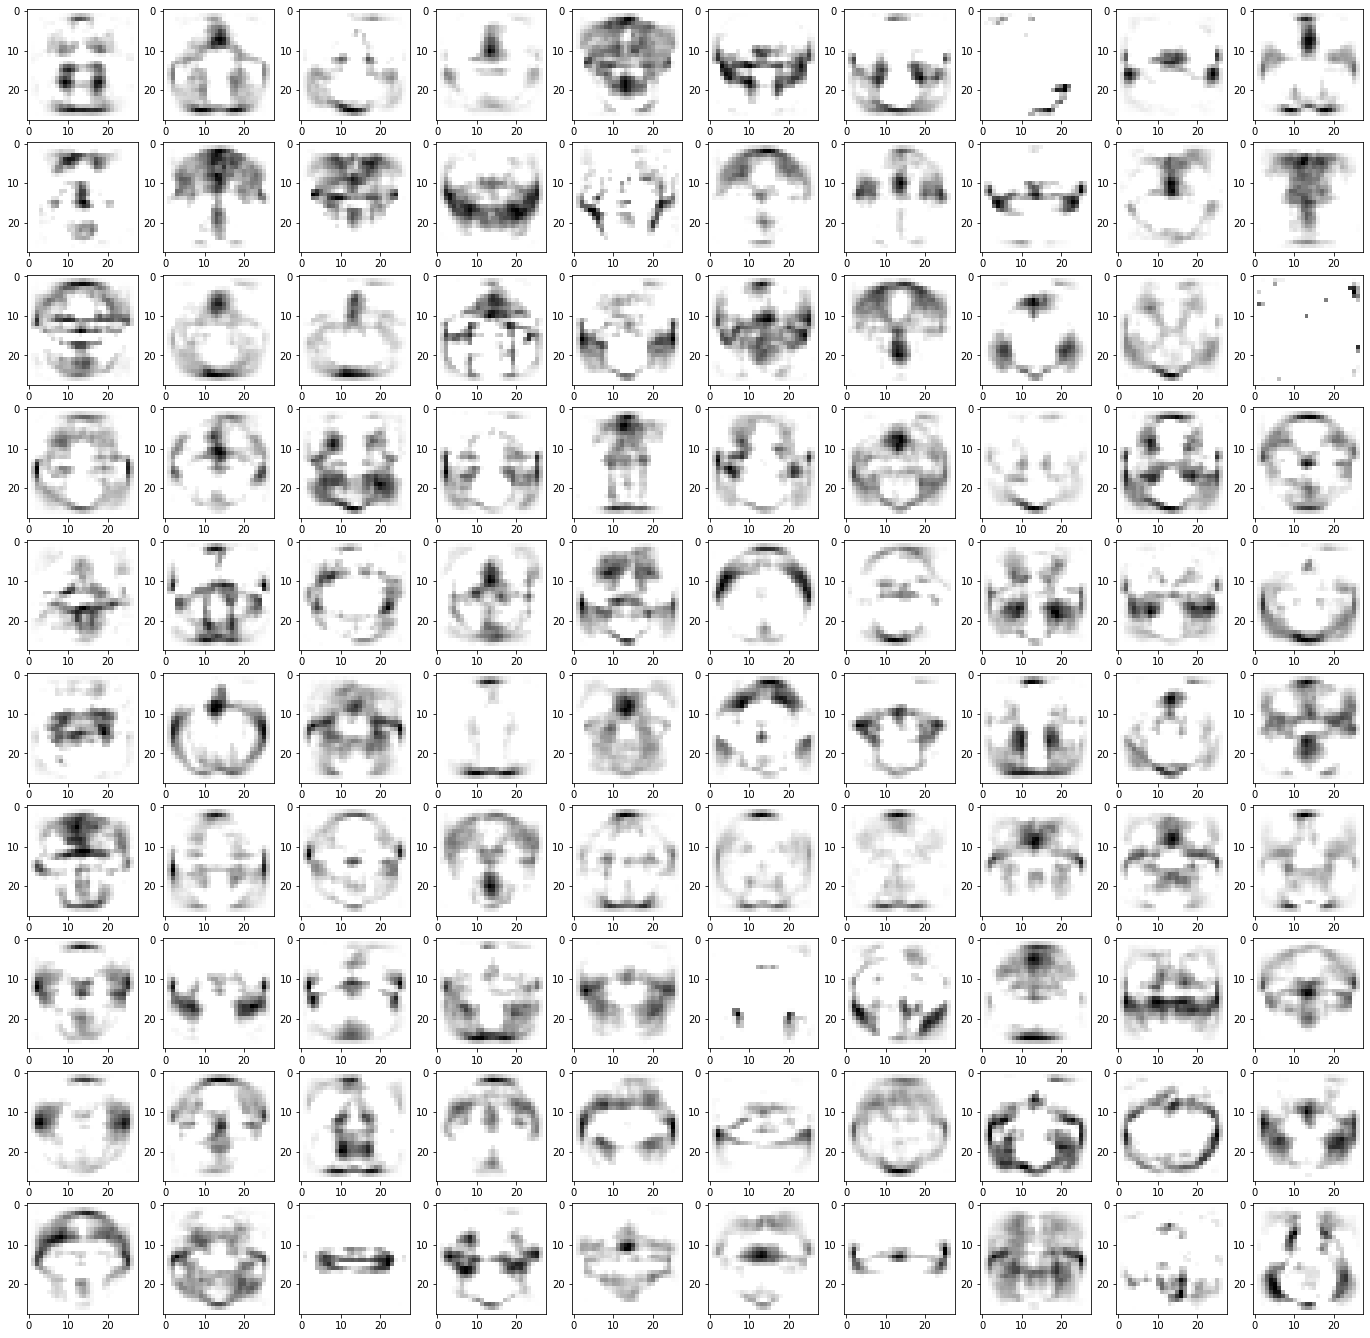

In [9]:
l0_weights = model.get_parameter('mlp_stack.0.weight').detach()
l0_weights_diff = l0_weights- old_weights
f, axs = plt.subplots(10,10,figsize=(24,24))
axs = axs.flatten()
start=300
for i in range(start,start+100):
    axs[i-start].imshow(l0_weights_diff[i].clip(min=0).view(28,28), cmap="gray_r")

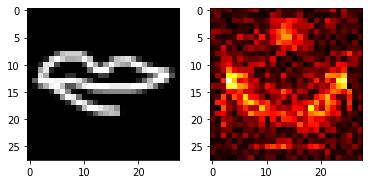

In [10]:
test_batch, test_batch_label = next(iter(test_dataloader))

image = test_batch[61]


fig, axs = plt.subplots(1,2, figsize=(6,6))
axs= axs.flatten()
axs[0].imshow(image.view(28,28), cmap='gray')

x_in = image.clone().requires_grad_()
model.zero_grad()
pred = model(x_in)
pred_index = pred.argmax()
pred_max = pred[ pred_index]
# print(pred_max)
pred_max.backward()

# saliency = nn.ReLU()(x_in.grad)
saliency = x_in.grad.detach().abs()
# print(saliency.shape, saliency)
saliency = saliency.reshape(28, 28)

axs[1].imshow(saliency, cmap="hot")


plt.show()

ground truth: 3 / car
predcition: 3 / car
attacked prediction: 1 / apple


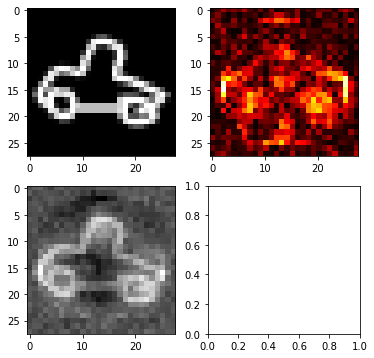

In [46]:
test_batch, test_batch_label = next(iter(test_dataloader))

item_id = 23

image = test_batch[item_id]
print(f"ground truth: {np.argmax(test_batch_label[item_id])} / {label_for_id(np.argmax(test_batch_label[item_id]))}")

fig, axs = plt.subplots(2,2, figsize=(6,6))
axs= axs.flatten()

axs[0].imshow(image.view(28,28), cmap='gray')

x_in = image.clone().requires_grad_()
model.zero_grad()
pred = model(x_in)
pred_index = pred.argmax()
print(f"predcition: {pred_index.item()} / {label_for_id(pred_index.item())}")
pred_max = pred[ pred_index]
# print(pred_max)
pred_max.backward()


saliency = x_in.grad.detach().abs()
# print(saliency.shape, saliency)
saliency = saliency.reshape(28, 28)
axs[1].imshow(saliency, cmap="hot")

model.zero_grad()
pred = model(x_in)
pred_attack = pred[1]
pred_attack.backward()
# print(x_in.grad)
x_attack = 0.3 *image + .9 *(x_in.grad.detach()) #nn.ReLU() // .sign()...

axs[2].imshow(x_attack.view(28,28), cmap='gray')
pred = model(x_attack)
pred_index = pred.argmax()
print(f'attacked prediction: {pred_index.item()} / {label_for_id(pred_index.item())}')

plt.show()

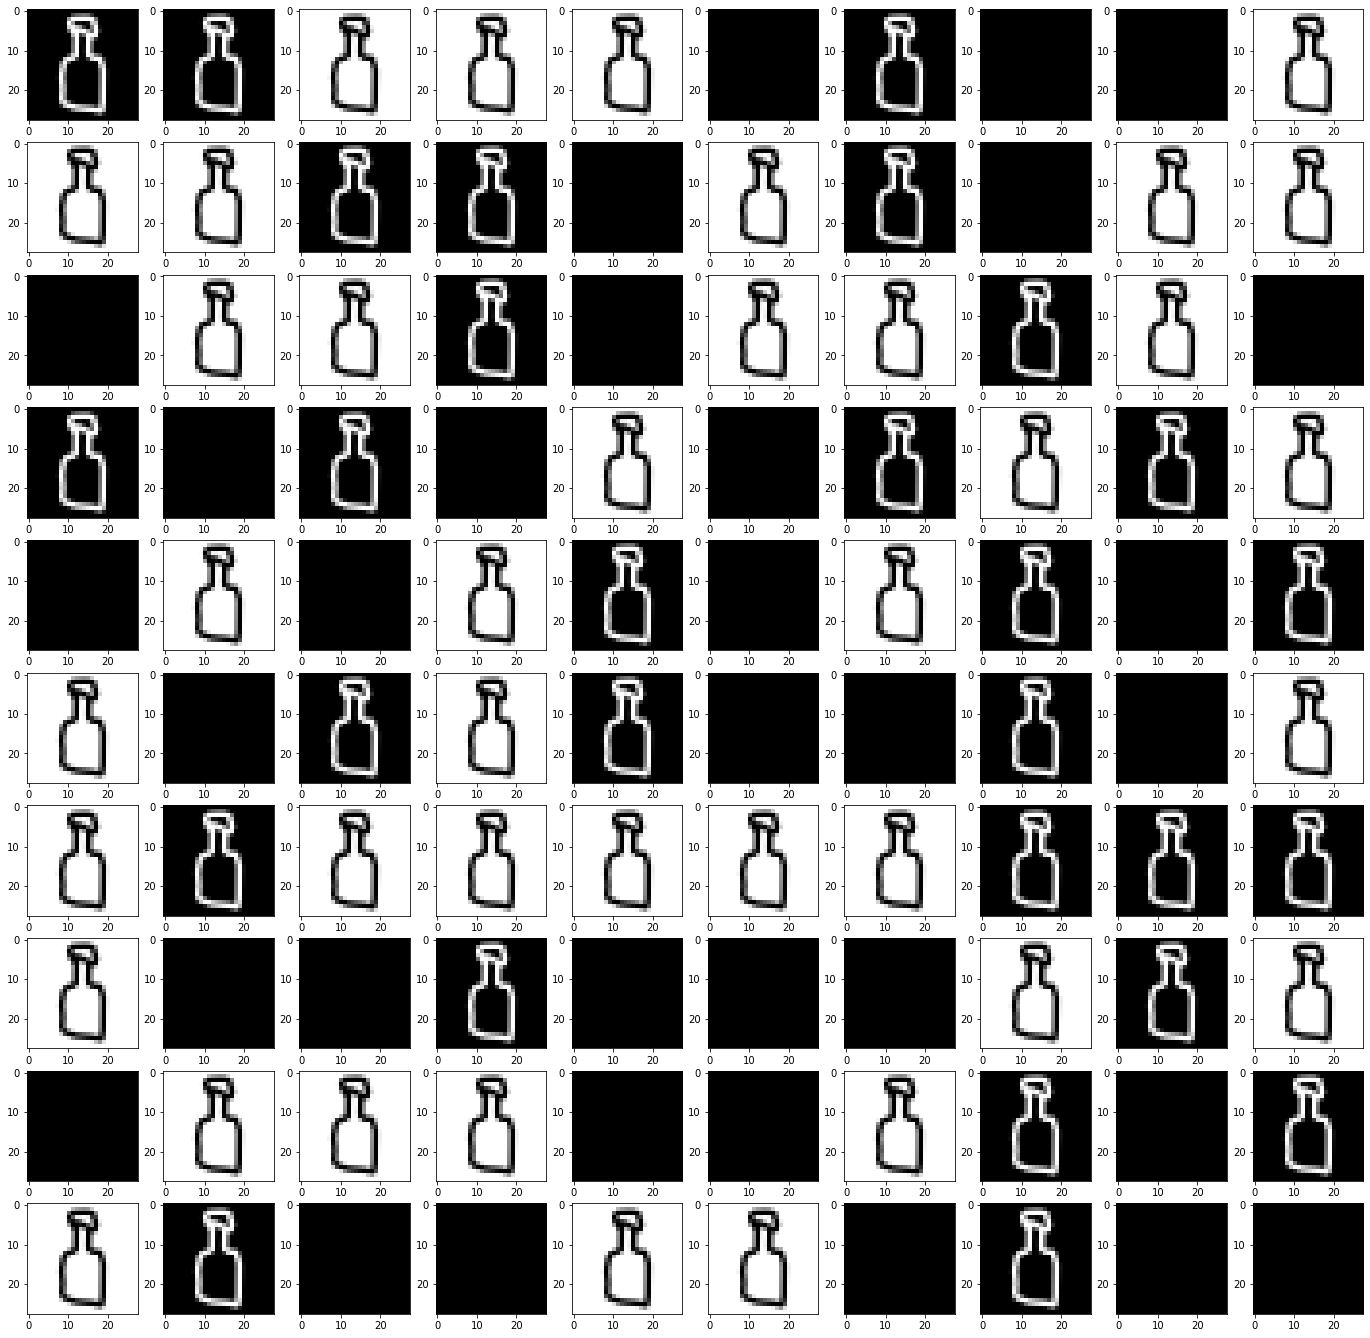

In [12]:
grads = model.get_parameter('mlp_stack.0.weight').grad.detach()
f, axs = plt.subplots(10,10,figsize=(24,24))
axs = axs.flatten()
start=300
for i in range(start,start+100):
    axs[i-start].imshow(grads[i].view(28,28), cmap="gray")